In [1]:
from gensim.models import KeyedVectors
glove_input_file = './util/glove.twitter.27B.200d.txt'
# glove_input_file = './util/glove.6B.100d.txt'

# Load GloVe vectors directly into a KeyedVectors instance
model = KeyedVectors.load_word2vec_format(glove_input_file, binary=False, no_header=True)

In [2]:
# Import package
import pandas as pd
import numpy as np

from tqdm import tqdm

In [3]:
df = pd.read_csv("./sample-clothes.csv")
df = df[['Review', 'Title']].reset_index(names='id').rename(columns={'Review': 'review'})
df['review'] = df['Title'] + ' '+ df['review']
df = df.drop('Title', axis=1)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      100 non-null    int64 
 1   review  100 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.7+ KB
None


,id,review
0,0,So flattering and so comfortable! I am in love...
1,1,"Cute but It Pills Great color and pattern, wit..."
2,2,It fell apart after one wash One set fell apar...
3,3,"Comfortable, nice color, but LOTS of pilling. ..."
4,4,"Cute dress that.even a short, skinny old woman..."


# Normalization

In [4]:
import util.normalization as norm

In [5]:
# Tokenization into sentence

df_st = df[['id', 'review']].copy()

# Sentence Tokenization
df_st['token_sentence'] = df_st['review'].apply(norm.sentence_tokenize)
df_st = df_st.explode('token_sentence')
df_st['token_sentence'] = df_st['token_sentence'].str.strip()

# Remove non-ASCII
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.remove_non_ascii)

# Expand contractions
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.expand_contractions)

# Remove characters
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.remove_characters, args=(True,))

# Remove enter tab
df_st['token_clean'] = df_st['token_sentence'].apply(norm.remove_enter_tab)

# Lemmatization
df_st['token_clean'] = df_st['token_clean'].apply(norm.lemmatize_text)

In [6]:
print(df_st.info())
df_st.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 0 to 99
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              520 non-null    int64 
 1   review          520 non-null    object
 2   token_sentence  520 non-null    object
 3   token_clean     520 non-null    object
dtypes: int64(1), object(3)
memory usage: 20.3+ KB
None


,id,review,token_sentence,token_clean
0,0,So flattering and so comfortable! I am in love...,So flattering and so comfortable!,so flattering and so comfortable !
0,0,So flattering and so comfortable! I am in love...,I am in love with this dress!,i be in love with this dress !
0,0,So flattering and so comfortable! I am in love...,It has a relaxed fit style as described,it have a relaxed fit style as described
0,0,So flattering and so comfortable! I am in love...,and I received compliments from my sister and ...,and i receive compliment from my sister and a ...
0,0,So flattering and so comfortable! I am in love...,It has pockets and a zipper on the left side.,it have pocket and a zipper on the left side .


# Determine Aspect with LDA

In [7]:
import util.model as models
import util.utility as util
from util.utility import get_topics, predict_topic
from util.normalization import preprocess_lda

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
df_st['token_clean'].values

array(['so flattering and so comfortable !',
       'i be in love with this dress !',
       'it have a relaxed fit style as described',
       'and i receive compliment from my sister and a stranger when i be do grocery haha .',
       'it have pocket and a zipper on the left side .',
       'the fabric be breathable and comfortable .',
       'it fit perfectly and have the perfect length .',
       'i pair it with beige sandal and a beige crossbody bag for a casual look .',
       "for reference i be 5 ' 1 and get a size extra small .",
       'you can also click my name to see my profile for more item i love !',
       'cute but it pill great color and pattern',
       'with the on trend slouchy look without be too oversized .',
       'material begin to pill after first wearing',
       'and become bad after first washing .',
       'did launder inside out in cold on hand wash cycle and line dry .',
       'it fell apart after one wash one set fell apart after one wash. thread come

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

texts = df_st['token_clean'].values

# Vectorize the texts using CountVectorizer
vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)

optimal_model, vectorizer = models.get_opt_lda_model(texts, vectorizer) 

C:\Users\Baha Tegar\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [10]:
# Print the topics
def print_topics(model, vectorizer, num_words=10):
    topics = model.components_
    feature_names = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(topics):
        print(f"Topic {idx + 1}:")
        print([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]])
        print([topic.argsort()[:-num_words - 1: -1]])

print_topics(optimal_model, vectorizer)

Topic 1:
['fabric', 'quality', 'good', 'price', 'guess', 'beautiful', 'wash', 'side', 'lightweight', 'large']
[array([129, 324, 162, 316, 168,  31, 477, 368, 219, 207], dtype=int64)]
Topic 2:
['size', 'comfortable', 'cute', 'super', 'true', 'great', 'little', 'waist', 'review', 'wash']
[array([373,  78,  94, 421, 450, 164, 224, 473, 340, 477], dtype=int64)]
Topic 3:
['pant', 'small', 'pocket', 'wear', 'look', 'dress', 'knee', 'shirt', 'order', 'print']
[array([281, 381, 306, 481, 228, 114, 203, 363, 268, 317], dtype=int64)]
Topic 4:
['order', 'material', 'color', 'quality', 'dress', 'wash', 'petite', 'second', 'pair', 'small']
[array([268, 238,  73, 324, 114, 477, 294, 354, 276, 381], dtype=int64)]
Topic 5:
['sweater', 'white', 'soft', 'size', 'blue', 'warm', 'wash', 'stripe', 'comfy', 'cold']
[array([423, 488, 385, 373,  38, 476, 477, 411,  79,  71], dtype=int64)]
Topic 6:
['dress', 'perfect', 'purchase', 'color', 'flatter', 'great', 'good', 'beautiful', 'sure', 'time']
[array([114, 2

In [11]:
dict_topics = get_topics(optimal_model, vectorizer, 0.15)
print(dict_topics)

{0: {'quality', 'good', 'fabric'}, 1: {'comfortable', 'size'}, 2: {'pocket', 'small', 'pant', 'wear'}, 3: {'material', 'order'}, 4: {'white', 'blue', 'sweater', 'warm', 'soft'}, 5: {'dress'}, 6: {'nice', 'side', 'large', 'short', 'style'}}


In [12]:
predict_topic("it have a relaxed fit style as described", optimal_model, vectorizer)

6

In [13]:
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation
# from gensim.models.coherencemodel import CoherenceModel
# import gensim.corpora as corpora
# from nltk.tokenize import word_tokenize
# import re

# # Preprocessing function
# def preprocess(text):
#     text = re.sub(r'[.,?!]', '', text)
#     tokens = word_tokenize(text.lower())
#     return tokens

# # Example texts
# texts = df_st['token_clean'].apply(norm.remove_stopwords, args=(True, )).values

# # Preprocess texts
# processed_texts = [preprocess(text) for text in texts]

# # Create dictionary and corpus for Gensim
# id2word = corpora.Dictionary(processed_texts)
# corpus = [id2word.doc2bow(text) for text in processed_texts]

# # Vectorize the texts using CountVectorizer
# vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
# X = vectorizer.fit_transform(processed_texts)

# # Function to compute coherence values
# def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
#     coherence_values = []
#     model_list = []
#     for num_topics in range(start, limit, step):
#         lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
#         lda.fit(X)
        
#         # Create topic-word distribution
#         topics = lda.components_
#         feature_names = vectorizer.get_feature_names_out()
#         topic_words = []
#         for topic in topics:
#             topic_words.append([feature_names[i] for i in topic.argsort()[:-11:-1]])
        
#         # Use Gensim CoherenceModel to compute coherence score
#         coherence_model = CoherenceModel(topics=topic_words, texts=processed_texts, dictionary=dictionary, coherence='c_v')
#         coherence_values.append(coherence_model.get_coherence())
        
#         model_list.append(lda)
#     return model_list, coherence_values

# # Set the range for the number of topics
# start, limit, step = 2, 10, 1

# # Compute coherence values
# model_list, coherence_values = compute_coherence_values(id2word, corpus, processed_texts, limit, start, step)

# # Find the optimal number of topics
# optimal_num_topics = start + coherence_values.index(max(coherence_values))

# print(f"Optimal number of topics: {optimal_num_topics}")
# print(f"Coherence values: {coherence_values}")

# # Train the optimal model
# optimal_model = LatentDirichletAllocation(n_components=optimal_num_topics, random_state=42)
# optimal_model.fit(X)

# # Print the topics
# def print_topics(model, vectorizer, num_words=10):
#     topics = model.components_
#     feature_names = vectorizer.get_feature_names_out()
#     for idx, topic in enumerate(topics):
#         print(f"Topic {idx + 1}:")
#         print([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]])

# print_topics(optimal_model, vectorizer)

# # Function to predict the topic distribution of a new document
# def predict_topic(text, model, vectorizer):
#     # Preprocess the text
#     processed_text = preprocess(text)
#     # Transform the text to the vector space
#     text_vectorized = vectorizer.transform([processed_text])
#     # Predict the topic distribution
#     topic_distribution = model.transform(text_vectorized)
#     # Get the most likely topic
#     topic = np.argmax(topic_distribution)
#     return topic, topic_distribution

# # New document
# new_document = "The battery of this laptop lasts a long time and the display is very clear."

# # Predict the topic
# predicted_topic, topic_distribution = predict_topic(new_document, optimal_model, vectorizer)

# print(f"Predicted topic: {predicted_topic}")
# print(f"Topic distribution: {topic_distribution}")

# # Print the topics for reference
# print_topics(optimal_model, vectorizer)


In [14]:
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation
# from gensim.models.coherencemodel import CoherenceModel
# import gensim.corpora as corpora
# from nltk.tokenize import word_tokenize
# import re

# import re
# import string
# import nltk
# import spacy
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize, sent_tokenize
# from nltk.tag import pos_tag
# from nltk.stem import WordNetLemmatizer

# # # Preprocessing function
# # def remove_emotion_char(text):
# #     text = re.sub(r'[.,?!]', '', text)
# #     return text

# # Load Spacy model
# nlp = spacy.load('en_core_web_sm')

# # Initialize lemmatizer and stop words
# lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))

# def preprocess_text(text):
#     # Step 1: Removing encodings and special characters
#     text = re.sub(r'[^\x00-\x7F]+', ' ', text)
#     text = re.sub(r'[^a-zA-Z\s]', '', text)

#     # Step 2: Tokenize sentence
#     sentences = sent_tokenize(text)

#     # Initialize a list to hold processed words
#     processed_words = []

#     for sentence in sentences:
#         # Step 3: Tokenize words
#         words = word_tokenize(sentence)

#         # Step 4: POS tag words
#         pos_tagged_words = pos_tag(words)

#         for word, tag in pos_tagged_words:
#             # Step 5: Get words that are only adjective-noun pairs or only noun
#             if tag in ['NN', 'NNS', 'NNP', 'NNPS', 'JJ']:
#                 # Step 6: Remove punctuation (already done in step 1)
#                 word = word.translate(str.maketrans('', '', string.punctuation))
                
#                 # Step 7: Remove all small words (length <= 3)
#                 if len(word) > 3:
#                     # Step 8: Lowercase words
#                     word = word.lower()

#                     # Step 9: Remove stop words
#                     if word not in stop_words:
#                         # Step 10: Lemmatize
#                         word = lemmatizer.lemmatize(word)

#                         # Add to the list of processed words
#                         processed_words.append(word)

#     return processed_words

# # Example texts
# # texts = df_st['token_clean'].apply(norm.remove_stopwords, args=(True, ))
# # texts = texts.apply(remove_emotion_char).values
# texts = df_st['token_clean'].values

# vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)

# def get_opt_lda_model(corpus, vectorizer, start=2, limit=10, step=1):
    
#     """
#     Get optimum LDA based on its number of topic.
#     """
    
# #     word_text = [word_tokenize(document) for document in corpus]
#     word_text = [preprocess_text(document) for document in corpus]
#     id2word_gm = corpora.Dictionary(word_text)
#     corpus_gm = [id2word_gm.doc2bow(text) for text in word_text]
    
    
#     # Vectorizer the text using CountVectorizer
#     X = vectorizer.fit_transform(word_text)
    
    
#     # Function to compute coherence values
#     def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
#         coherence_values = []
#         model_list = []
#         for num_topics in range(start, limit, step):
#             lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
#             lda.fit(X)

#             # Create topic-word distribution
#             topics = lda.components_
#             feature_names = vectorizer.get_feature_names_out()
#             topic_words = []
#             for topic in topics:
#                 topic_words.append([feature_names[i] for i in topic.argsort()[:-11:-1]])

#             # Use Gensim CoherenceModel to compute coherence score
#             coherence_model = CoherenceModel(topics=topic_words, texts=texts,
#                                                                dictionary=dictionary, coherence='c_v', corpus=corpus)
#             coherence_values.append(coherence_model.get_coherence())

#             model_list.append(lda)
#         return model_list, coherence_values
    

#     # Compute coherence values
#     model_list, coherence_values = compute_coherence_values(id2word_gm, corpus_gm, word_text, limit, start, step)
#     # Find the optimal number of topics
#     optimal_num_topics = start + coherence_values.index(max(coherence_values))

#     # Train the optimal model
#     optimal_model = LatentDirichletAllocation(n_components=optimal_num_topics, random_state=42)
#     optimal_model.fit(X)
    
#     return optimal_model, vectorizer

# optimal_model, vectorizer = get_opt_lda_model(texts, vectorizer)  

In [15]:
# def get_topics(model, vectorizer, threshold=0.1):
    
#     """
#     Get topic-distribution word as dictionary. The selected distribution word is determined
#     by parameter threshold.
    
#     """
#     topics = model.components_
#     feature_names = vectorizer.get_feature_names_out()
    
#     components_normalize = topics / topics.sum(axis=1)[:, np.newaxis]

#     result = {k: {} for k in range(len(components_normalize))}

#     added_keys = []
#     for idx, component in enumerate(components_normalize):
#         temp = {k: v for k, v in zip(feature_names, component)}
#         sorted_data = dict(sorted(temp.items(), key=lambda x: x[1], reverse=True))
#         cumulative_sum = 0
#         filtered_data = {}

#         # Iterate through the sorted dictionary and accumulate the sum

#         for key, value in sorted_data.items():
#             if re.search(r'[^a-zA-Z0-9]', key):
#                 continue
#             if key not in added_keys:
#                 added_keys.append(key)
#                 if cumulative_sum + value < threshold:
#                     cumulative_sum += value
#                     filtered_data[key] = value
#                 else:
#                     break
#         print(filtered_data)
#         result[idx] = set(filtered_data.keys())
#     return result


# dict_topics = get_topics(optimal_model, vectorizer, 0.25)
# print(dict_topics)

In [16]:
# # Function to predict the topic distribution of a new document
# def predict_topic(text, model, vectorizer, threshold=0.0):
#     # Pre-processing
#     text = preprocess_text(text)
#     # Transform the text to the vector space
#     text_vectorized = vectorizer.transform([text])
#     # Predict the topic distribution
#     topic_distribution = model.transform(text_vectorized)
#     # Get the most likely topic
#     topic = np.argmax(topic_distribution)
    
# #     print(topic_distribution)
# #     print(topic)
# #     print(topic_distribution[0][topic])
#     if topic_distribution[0][topic] < threshold:
#         return None
#     return topic

# predict_topic("it have a relaxed fit style as described", optimal_model, vectorizer)

In [17]:
util.get_nearest_word("it have a relaxed fit style as described", list(dict_topics[1]), model,
                      threshold=0.0, get_all=True)

{'comfortable': 0.5804764032363892, 'size': 0.4844760596752167}

In [18]:
def fun(x, threshold=0.0):
    cat = predict_topic(x, optimal_model, vectorizer)
    if not cat:
        return set()
    topic = dict_topics[cat]
    result = util.get_nearest_word(x, topic, model, threshold=threshold, get_all=True)
    return set(result.keys())
    

df_st['topic_lda'] = df_st['token_clean'].apply(fun, args=(0.65,))
df_st['cat_topic_lda'] = df_st['token_clean'].apply(predict_topic, args=(optimal_model, vectorizer,))

In [19]:
df_st

,id,review,token_sentence,token_clean,topic_lda,cat_topic_lda
0,0,So flattering and so comfortable! I am in love...,So flattering and so comfortable!,so flattering and so comfortable !,{},1
0,0,So flattering and so comfortable! I am in love...,I am in love with this dress!,i be in love with this dress !,{},1
0,0,So flattering and so comfortable! I am in love...,It has a relaxed fit style as described,it have a relaxed fit style as described,"{nice, style, side}",6
0,0,So flattering and so comfortable! I am in love...,and I received compliments from my sister and ...,and i receive compliment from my sister and a ...,"{nice, side}",6
0,0,So flattering and so comfortable! I am in love...,It has pockets and a zipper on the left side.,it have pocket and a zipper on the left side .,{},0
...,...,...,...,...,...,...
99,99,"Cute, with reservations First one i received w...",on the positive side,on the positive side,"{nice, side}",6
99,99,"Cute, with reservations First one i received w...",it is very cute and i am keeping the replaceme...,it be very cute and i be keep the replacement one,{small},2
99,99,"Cute, with reservations First one i received w...",but know that it is also delicate.,but know that it be also delicate .,{},4
99,99,"Cute, with reservations First one i received w...",after one use,after one use,{},0


In [21]:
df_st['cat_topic_lda'].value_counts()

0    112
1     89
5     86
4     67
2     58
3     57
6     51
Name: cat_topic_lda, dtype: int64

# Get Aspect

In [22]:
tqdm.pandas()
df_st['sub_aspect'] = df_st['token_clean'].progress_apply(util.get_aspect_rules)

100%|████████████████████████████████████████████████████████████████████████████████| 520/520 [00:50<00:00, 10.28it/s]


In [23]:
# array_rule = df_st['rule_aspect'].values
# array_lda = df_st['lda_aspect'].values
# result = []
# for i in range(df_st.shape[0]):
#     if (len(array_rule[i]) > 0) and (array_lda[i]):
#         set1 = array_rule[i]
#         set2 = array_lda[i]
#         result.append(set1.union(set2))
#     else:
#         result.append(set())
        
# df_st['sub_aspect'] = result

In [24]:
df_st

,id,review,token_sentence,token_clean,topic_lda,cat_topic_lda,sub_aspect
0,0,So flattering and so comfortable! I am in love...,So flattering and so comfortable!,so flattering and so comfortable !,{},1,{}
0,0,So flattering and so comfortable! I am in love...,I am in love with this dress!,i be in love with this dress !,{},1,{}
0,0,So flattering and so comfortable! I am in love...,It has a relaxed fit style as described,it have a relaxed fit style as described,"{nice, style, side}",6,{fit style}
0,0,So flattering and so comfortable! I am in love...,and I received compliments from my sister and ...,and i receive compliment from my sister and a ...,"{nice, side}",6,"{grocery, compliment}"
0,0,So flattering and so comfortable! I am in love...,It has pockets and a zipper on the left side.,it have pocket and a zipper on the left side .,{},0,"{pocket, left side}"
...,...,...,...,...,...,...,...
99,99,"Cute, with reservations First one i received w...",on the positive side,on the positive side,"{nice, side}",6,{positive side}
99,99,"Cute, with reservations First one i received w...",it is very cute and i am keeping the replaceme...,it be very cute and i be keep the replacement one,{small},2,{replacement}
99,99,"Cute, with reservations First one i received w...",but know that it is also delicate.,but know that it be also delicate .,{},4,{}
99,99,"Cute, with reservations First one i received w...",after one use,after one use,{},0,{}


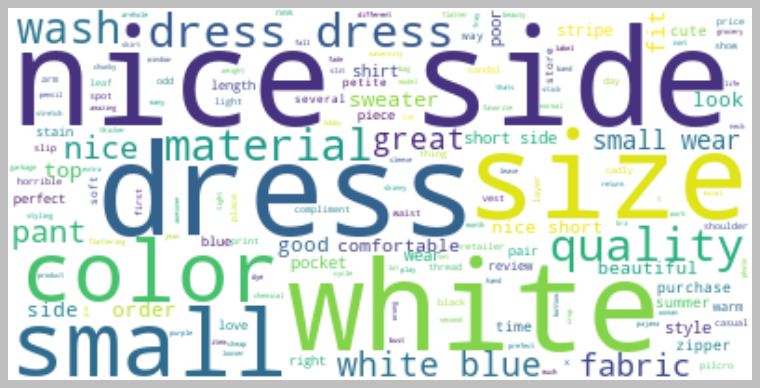

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ""
topic_lda = df_st['topic_lda'].values
sub_aspect = df_st['sub_aspect'].values
for i in range(df_st.shape[0]):
    text = text + " " + " ".join(list(topic_lda[i])) + " " + " ".join(list(sub_aspect[i]))
    

text = text.strip()

wordcloud = WordCloud(background_color='white').generate(text)
plt.style.use('classic')
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [26]:
np.concatenate([topic_lda, sub_aspect])

array([set(), set(), {'nice', 'style', 'side'}, ..., set(), set(), set()],
      dtype=object)

In [27]:
sub_aspect

array([set(), set(), {'fit style'}, {'grocery', 'compliment'},
       {'pocket', 'left side'}, {'fabric'}, {'perfect length'},
       {'beige sandal', 'crossbody bag', 'casual look'}, {'size'},
       {'profile', 'more item', 'name'}, {'great color'},
       {'slouchy look'}, {'material'}, {'first washing'},
       {'hand wash', 'wash cycle'}, {'set', 'thread', 'wash'},
       {'string', 'tie'}, {'product info'}, set(), {'bad thing'}, set(),
       {'nice color'}, set(), {'fit'}, {'weight'}, set(),
       {'purchase', 'fabric'}, {'good care'}, {'look'}, {'thats'},
       {'cute dress', 'dress that.even'},
       {'old woman', 'woman skinny', 'necessary spot'}, {'material'},
       set(), {'nice pant', 'pair', 'horrible zipper', 'tendon'}, {'arm'},
       {'size'}, set(),
       {'window close', 'zipper unfortunately', 'pair', 'return window', 'time'},
       {'new zipper'}, {'rave review'}, {'vest'},
       {'fun figure', 'different outfit'},
       {'layer piece', 'season layer'},
   

In [28]:
all_topics_aspect = set()
concat = np.concatenate([topic_lda, sub_aspect])

for e in concat:
    if len(e) > 0:
        for a in e:
            all_topics_aspect.add(a)

all_topics_aspect

{'1st wash',
 'actual dress',
 'adjustability',
 'adorable dress',
 'amazing dress',
 'anyone',
 'anything',
 'arm',
 'armhole',
 'awesome top',
 'bad thing',
 'band detail',
 'base',
 'beautiful color',
 'beautiful dress',
 'beautiful pajama',
 'beautiful styling',
 'beauty',
 'beige sandal',
 'big bust',
 'black',
 'black dress',
 'blouse',
 'blue',
 'blue color',
 'blue jean',
 'blue stripe',
 'body type',
 'bottom',
 'bra',
 'bulky pocket',
 'bunch',
 'bust',
 'button',
 'cant sadly great',
 'cargo',
 'casual dining',
 'casual look',
 'casual pant',
 'cheap look',
 'cheap quality',
 'chemical smell',
 'chest',
 'chunky size',
 'clearance rack',
 'closet staple',
 'cloth',
 'colder month',
 'color',
 'color fade',
 'color wash',
 'columbia satisfied',
 'combo cotton',
 'comfort level',
 'comfortable',
 'comfortable dress',
 'comfortable sweater',
 'comfy fit',
 'compliment',
 'couple inch',
 'crop pant',
 'crossbody bag',
 'cut',
 'cute dress',
 'cute pant',
 'cute sweater',
 'cute 

In [49]:
aspects = ['color', 'size', 'quality']
# aspects = ['material', 'construction', 'color', 'finishing', 'durability']

def fun1(x):
    temp = set()
    for e in x:
        aspect = util.get_nearest_word(e, aspects, model)
        if aspect:
            temp.add(aspect)
    temp = list(temp)
    return temp

def fun2(x):
    result = util.get_nearest_word(" ".join(x), aspects, model, 0.45)
    print(util.get_nearest_word(" ".join(x), aspects, model, 0.45, get_all=True))
    if not result:
        return []
    return [result]
    
fun2(df_st['topic_lda'].iloc[0])

tqdm.pandas()
# df_st['sub_aspect'].apply(fun)
# df_st['aspect'] = df_st['sub_aspect'].progress_apply(lambda x: list({util.get_aspect(e, aspects=aspects, model=model) 
#                                                                      for e in x}))
# df_st['aspect'] = df_st['sub_aspect'].progress_apply(fun1)
# df_st['aspect'] = df_st['topic_lda'].progress_apply(fun2)
df_st['aspect'] = [list(set(fun1(i) + fun2(j))) for i,j in zip(df_st.sub_aspect, df_st.topic_lda)]
df_st

None
None
None
{'quality': 0.5694169402122498, 'color': 0.49765899777412415, 'size': 0.4896931052207947}
{'quality': 0.5467857718467712, 'size': 0.46582135558128357}
None
None
None
{'color': 0.641777515411377, 'size': 0.5188984274864197}
{'size': 0.5657232403755188, 'quality': 0.4602828323841095}
None
None
{'color': 0.5781444311141968, 'size': 0.4968942105770111}
None
None
None
None
None
{'quality': 0.5467857718467712, 'size': 0.46582135558128357}
None
None
{}
{'quality': 0.507936954498291, 'size': 0.4586039185523987}
None
None
None
{'color': 0.641777515411377, 'size': 0.5188984274864197}
None
None
{'size': 0.5657232403755188, 'quality': 0.4602828323841095}
None
{'size': 0.5179652571678162}
None
{'quality': 0.4659685492515564}
None
{'color': 0.5781444311141968, 'size': 0.4968942105770111}
{'color': 0.5781444311141968, 'size': 0.4968942105770111}
{'size': 1}
None
None
None
None
{'color': 0.641777515411377, 'size': 0.5188984274864197}
None
None
None
None
None
None
{'quality': 0.546785771

,id,review,token_sentence,token_clean,topic_lda,cat_topic_lda,sub_aspect,aspect,pattern_prediction,roberta_prediction,material_pattern,material_roberta,color_pattern,color_roberta,size_pattern,size_roberta,quality_pattern,quality_roberta
0,0,So flattering and so comfortable! I am in love...,So flattering and so comfortable!,so flattering and so comfortable !,{},1,{},[],positive,positive,0,0,0,0,0,0,0,0
0,0,So flattering and so comfortable! I am in love...,I am in love with this dress!,i be in love with this dress !,{},1,{},[],positive,positive,0,0,0,0,0,0,0,0
0,0,So flattering and so comfortable! I am in love...,It has a relaxed fit style as described,it have a relaxed fit style as described,"{nice, style, side}",6,{fit style},"[quality, size]",positive,positive,0,0,0,0,1,1,1,1
0,0,So flattering and so comfortable! I am in love...,and I received compliments from my sister and ...,and i receive compliment from my sister and a ...,"{nice, side}",6,"{grocery, compliment}","[color, quality]",positive,positive,0,0,1,1,0,0,1,1
0,0,So flattering and so comfortable! I am in love...,It has pockets and a zipper on the left side.,it have pocket and a zipper on the left side .,{},0,"{pocket, left side}","[quality, size]",negative,positive,0,0,0,0,-99,1,-99,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,99,"Cute, with reservations First one i received w...",on the positive side,on the positive side,"{nice, side}",6,{positive side},[quality],positive,positive,0,0,0,0,0,0,1,1
99,99,"Cute, with reservations First one i received w...",it is very cute and i am keeping the replaceme...,it be very cute and i be keep the replacement one,{small},2,{replacement},"[quality, size]",positive,positive,0,0,0,0,1,1,1,1
99,99,"Cute, with reservations First one i received w...",but know that it is also delicate.,but know that it be also delicate .,{},4,{},[],negative,positive,0,0,0,0,0,0,0,0
99,99,"Cute, with reservations First one i received w...",after one use,after one use,{},0,{},[],negative,positive,0,0,0,0,0,0,0,0


In [50]:
df_st['aspect'].value_counts()

[]                        151
[quality]                 107
[size]                     86
[quality, size]            59
[color]                    49
[color, quality]           28
[color, size]              27
[color, quality, size]     13
Name: aspect, dtype: int64

In [51]:
df_st.iloc[3]['token_sentence']

'and I received compliments from my sister and a stranger when I was doing groceries haha.'

In [52]:
models.roberta_model('and I received compliments from my sister and a stranger when I was doing groceries haha.')

'positive'

# Sentiment Analysis

In [53]:
import util.model as models

In [54]:
sample = df_st['token_clean'].iloc[4]
print(sample)
models.pattern_lexicon_model(sample)

it have pocket and a zipper on the left side .


'negative'

In [55]:
tqdm.pandas()
df_st['pattern_prediction'] = df_st['token_clean'].progress_apply(models.pattern_lexicon_model)

100%|██████████████████████████████████████████████████████████████████████████████| 520/520 [00:00<00:00, 3150.21it/s]


In [56]:
tqdm.pandas()
df_st['roberta_prediction'] = df_st['token_clean'].progress_apply(models.roberta_model)

100%|████████████████████████████████████████████████████████████████████████████████| 520/520 [14:20<00:00,  1.65s/it]


In [57]:
df_st

,id,review,token_sentence,token_clean,topic_lda,cat_topic_lda,sub_aspect,aspect,pattern_prediction,roberta_prediction,material_pattern,material_roberta,color_pattern,color_roberta,size_pattern,size_roberta,quality_pattern,quality_roberta
0,0,So flattering and so comfortable! I am in love...,So flattering and so comfortable!,so flattering and so comfortable !,{},1,{},[],positive,positive,0,0,0,0,0,0,0,0
0,0,So flattering and so comfortable! I am in love...,I am in love with this dress!,i be in love with this dress !,{},1,{},[],positive,positive,0,0,0,0,0,0,0,0
0,0,So flattering and so comfortable! I am in love...,It has a relaxed fit style as described,it have a relaxed fit style as described,"{nice, style, side}",6,{fit style},"[quality, size]",positive,positive,0,0,0,0,1,1,1,1
0,0,So flattering and so comfortable! I am in love...,and I received compliments from my sister and ...,and i receive compliment from my sister and a ...,"{nice, side}",6,"{grocery, compliment}","[color, quality]",positive,positive,0,0,1,1,0,0,1,1
0,0,So flattering and so comfortable! I am in love...,It has pockets and a zipper on the left side.,it have pocket and a zipper on the left side .,{},0,"{pocket, left side}","[quality, size]",negative,positive,0,0,0,0,-99,1,-99,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,99,"Cute, with reservations First one i received w...",on the positive side,on the positive side,"{nice, side}",6,{positive side},[quality],positive,positive,0,0,0,0,0,0,1,1
99,99,"Cute, with reservations First one i received w...",it is very cute and i am keeping the replaceme...,it be very cute and i be keep the replacement one,{small},2,{replacement},"[quality, size]",positive,positive,0,0,0,0,1,1,1,1
99,99,"Cute, with reservations First one i received w...",but know that it is also delicate.,but know that it be also delicate .,{},4,{},[],negative,positive,0,0,0,0,0,0,0,0
99,99,"Cute, with reservations First one i received w...",after one use,after one use,{},0,{},[],negative,positive,0,0,0,0,0,0,0,0


# Get Result

In [58]:
get_aspects = df_st['aspect'].values
get_pattern = df_st['pattern_prediction'].values
get_roberta = df_st['roberta_prediction'].values

def get_result(aspect, model):
    
    # Initialization
    get_aspects = df_st['aspect'].values
    get_predictions = df_st[model].values
    
    temp = []

    for i in range(len(get_aspects)):
        if (not get_aspects[i]) or (aspect not in get_aspects[i]):
            temp.append(0)
        else:
            if get_predictions[i] == 'negative':
                temp.append(-99)
            else:
                temp.append(1)
    return np.array(temp)

In [59]:
get_aspects = df_st['aspect'].values
get_pattern = df_st['pattern_prediction'].values
get_roberta = df_st['roberta_prediction'].values

new_fields = set()
for aspect in aspects:
    
    df_st[aspect + f"_pattern"] = get_result(aspect, 'pattern_prediction')
    df_st[aspect + f"_roberta"] = get_result(aspect, 'roberta_prediction')
    new_fields.add(aspect + f"_pattern")
    new_fields.add(aspect + f"_roberta")
new_fields = list(new_fields)
print(df_st.info())
df_st

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 0 to 99
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  520 non-null    int64 
 1   review              520 non-null    object
 2   token_sentence      520 non-null    object
 3   token_clean         520 non-null    object
 4   topic_lda           520 non-null    object
 5   cat_topic_lda       520 non-null    int64 
 6   sub_aspect          520 non-null    object
 7   aspect              520 non-null    object
 8   pattern_prediction  520 non-null    object
 9   roberta_prediction  520 non-null    object
 10  material_pattern    520 non-null    int32 
 11  material_roberta    520 non-null    int32 
 12  color_pattern       520 non-null    int32 
 13  color_roberta       520 non-null    int32 
 14  size_pattern        520 non-null    int32 
 15  size_roberta        520 non-null    int32 
 16  quality_pattern     520 non

,id,review,token_sentence,token_clean,topic_lda,cat_topic_lda,sub_aspect,aspect,pattern_prediction,roberta_prediction,material_pattern,material_roberta,color_pattern,color_roberta,size_pattern,size_roberta,quality_pattern,quality_roberta
0,0,So flattering and so comfortable! I am in love...,So flattering and so comfortable!,so flattering and so comfortable !,{},1,{},[],positive,positive,0,0,0,0,0,0,0,0
0,0,So flattering and so comfortable! I am in love...,I am in love with this dress!,i be in love with this dress !,{},1,{},[],positive,positive,0,0,0,0,0,0,0,0
0,0,So flattering and so comfortable! I am in love...,It has a relaxed fit style as described,it have a relaxed fit style as described,"{nice, style, side}",6,{fit style},"[quality, size]",positive,positive,0,0,0,0,1,1,1,1
0,0,So flattering and so comfortable! I am in love...,and I received compliments from my sister and ...,and i receive compliment from my sister and a ...,"{nice, side}",6,"{grocery, compliment}","[color, quality]",positive,positive,0,0,1,1,0,0,1,1
0,0,So flattering and so comfortable! I am in love...,It has pockets and a zipper on the left side.,it have pocket and a zipper on the left side .,{},0,"{pocket, left side}","[quality, size]",negative,positive,0,0,0,0,-99,1,-99,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,99,"Cute, with reservations First one i received w...",on the positive side,on the positive side,"{nice, side}",6,{positive side},[quality],positive,positive,0,0,0,0,0,0,1,1
99,99,"Cute, with reservations First one i received w...",it is very cute and i am keeping the replaceme...,it be very cute and i be keep the replacement one,{small},2,{replacement},"[quality, size]",positive,positive,0,0,0,0,1,1,1,1
99,99,"Cute, with reservations First one i received w...",but know that it is also delicate.,but know that it be also delicate .,{},4,{},[],negative,positive,0,0,0,0,0,0,0,0
99,99,"Cute, with reservations First one i received w...",after one use,after one use,{},0,{},[],negative,positive,0,0,0,0,0,0,0,0


In [60]:
grouped_df = df_st[ ['id'] + new_fields ].groupby('id').sum()

grouped_df = grouped_df.applymap(lambda x: 0 if x < 0 else 1).reset_index()

grouped_df

,id,color_roberta,color_pattern,size_pattern,quality_roberta,quality_pattern,size_roberta
0,0,1,0,0,1,0,1
1,1,1,0,0,0,0,1
2,2,0,0,0,0,0,0
3,3,0,0,0,1,0,0
4,4,1,1,0,1,0,1
...,...,...,...,...,...,...,...
95,95,1,0,0,1,0,1
96,96,1,0,0,1,1,0
97,97,1,1,1,1,1,1
98,98,0,0,0,0,0,1


In [61]:
result = df.merge(grouped_df, on='id', how='left')

print(result.info())
result.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               100 non-null    int64 
 1   review           100 non-null    object
 2   color_roberta    100 non-null    int64 
 3   color_pattern    100 non-null    int64 
 4   size_pattern     100 non-null    int64 
 5   quality_roberta  100 non-null    int64 
 6   quality_pattern  100 non-null    int64 
 7   size_roberta     100 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 7.0+ KB
None


,id,review,color_roberta,color_pattern,size_pattern,quality_roberta,quality_pattern,size_roberta
0,0,So flattering and so comfortable! I am in love...,1,0,0,1,0,1
1,1,"Cute but It Pills Great color and pattern, wit...",1,0,0,0,0,1
2,2,It fell apart after one wash One set fell apar...,0,0,0,0,0,0
3,3,"Comfortable, nice color, but LOTS of pilling. ...",0,0,0,1,0,0
4,4,"Cute dress that.even a short, skinny old woman...",1,1,0,1,0,1


In [62]:
result['color_roberta'].value_counts()

1    79
0    21
Name: color_roberta, dtype: int64

# Evaluation

In [63]:
df_val = pd.read_csv('validation-clothes.csv').dropna()

print(df_val.info())
df_val.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         100 non-null    object
 1   Review        100 non-null    object
 2   Cons_rating   100 non-null    int64 
 3   Cloth_class   100 non-null    object
 4   Materials     100 non-null    int64 
 5   Construction  100 non-null    int64 
 6   Color         100 non-null    int64 
 7   Finishing     100 non-null    int64 
 8   Durability    100 non-null    int64 
 9   material      100 non-null    object
 10  fabric        100 non-null    object
 11  color         100 non-null    object
 12  size          100 non-null    object
 13  quality       100 non-null    object
dtypes: int64(6), object(8)
memory usage: 11.1+ KB
None


,Title,Review,Cons_rating,Cloth_class,Materials,Construction,Color,Finishing,Durability,material,fabric,color,size,quality
0,So flattering and so comfortable!,I am in love with this dress! It has a relaxed...,5,Dresses,0,1,0,1,0,Positive,Positive,Neutral,Positive,Positive
1,Cute but It Pills,"Great color and pattern, with the on trend “sl...",3,Sweaters,0,0,1,0,1,Negative,Negative,Positive,Positive,Negative
2,It fell apart after one wash,One set fell apart after one wash. Threads cam...,1,Sleep,0,0,1,0,1,Negative,Negative,Negative,Negative,Negative
3,"Comfortable, nice color, but LOTS of pilling.","I like the fit, weight, and color of this swea...",3,Sweaters,1,1,1,0,0,Negative,Negative,Positive,Positive,Negative
4,"Cute dress that.even a short, skinny old woman...",Material is sheer. Make sure you aren't embarr...,5,Dresses,1,0,0,0,0,Negative,Negative,Neutral,Neutral,Negative


In [64]:
def mapping_sentiment(x):
    if x == 'Negative':
        return 0
    else:
        return 1    

def join_aspect(x, y):
    if x==1 and y==1:
        return 1
    else:
        return 0

for aspect in aspects:
    df_val[aspect] = df_val[aspect].apply(mapping_sentiment)

# df_val['service'] = [join_aspect(x, y) for x, y in zip(df_val.service, df_val.order)]
# df_val = df_val.drop('order', axis=1)
print(df_val.info())
df_val.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         100 non-null    object
 1   Review        100 non-null    object
 2   Cons_rating   100 non-null    int64 
 3   Cloth_class   100 non-null    object
 4   Materials     100 non-null    int64 
 5   Construction  100 non-null    int64 
 6   Color         100 non-null    int64 
 7   Finishing     100 non-null    int64 
 8   Durability    100 non-null    int64 
 9   material      100 non-null    object
 10  fabric        100 non-null    object
 11  color         100 non-null    int64 
 12  size          100 non-null    int64 
 13  quality       100 non-null    int64 
dtypes: int64(9), object(5)
memory usage: 11.1+ KB
None


,Title,Review,Cons_rating,Cloth_class,Materials,Construction,Color,Finishing,Durability,material,fabric,color,size,quality
0,So flattering and so comfortable!,I am in love with this dress! It has a relaxed...,5,Dresses,0,1,0,1,0,Positive,Positive,1,1,1
1,Cute but It Pills,"Great color and pattern, with the on trend “sl...",3,Sweaters,0,0,1,0,1,Negative,Negative,1,1,0
2,It fell apart after one wash,One set fell apart after one wash. Threads cam...,1,Sleep,0,0,1,0,1,Negative,Negative,0,0,0
3,"Comfortable, nice color, but LOTS of pilling.","I like the fit, weight, and color of this swea...",3,Sweaters,1,1,1,0,0,Negative,Negative,1,1,0
4,"Cute dress that.even a short, skinny old woman...",Material is sheer. Make sure you aren't embarr...,5,Dresses,1,0,0,0,0,Negative,Negative,1,1,0


In [65]:
from sklearn.metrics import classification_report, roc_auc_score

print("Prediction pattern")
print("==============================================================")
for aspect in aspects:
    actual = df_val[aspect]
    pred = result[aspect + "_pattern"]
    print(f"ROC AUC Score: ", roc_auc_score(actual, pred))
    print(f"Result {aspect}")
    print(classification_report(actual, pred))

Prediction pattern
ROC AUC Score:  0.8111111111111111
Result color
              precision    recall  f1-score   support

           0       0.26      0.90      0.41        10
           1       0.98      0.72      0.83        90

    accuracy                           0.74       100
   macro avg       0.62      0.81      0.62       100
weighted avg       0.91      0.74      0.79       100

ROC AUC Score:  0.6416504223521767
Result size
              precision    recall  f1-score   support

           0       0.27      0.79      0.40        19
           1       0.91      0.49      0.64        81

    accuracy                           0.55       100
   macro avg       0.59      0.64      0.52       100
weighted avg       0.79      0.55      0.59       100

ROC AUC Score:  0.7609678878335595
Result quality
              precision    recall  f1-score   support

           0       0.52      0.97      0.67        33
           1       0.97      0.55      0.70        67

    accuracy      

In [66]:
print("Prediction roberta")
print("==============================================================")
for aspect in aspects:
    actual = df_val[aspect]
    pred = result[aspect + "_roberta"]
    print(f"ROC AUC Score: ", roc_auc_score(actual, pred))
    print(f"Result {aspect}")
    print(classification_report(actual, pred))

Prediction roberta
ROC AUC Score:  0.7722222222222221
Result color
              precision    recall  f1-score   support

           0       0.33      0.70      0.45        10
           1       0.96      0.84      0.90        90

    accuracy                           0.83       100
   macro avg       0.65      0.77      0.68       100
weighted avg       0.90      0.83      0.85       100

ROC AUC Score:  0.6968810916179338
Result size
              precision    recall  f1-score   support

           0       0.42      0.58      0.49        19
           1       0.89      0.81      0.85        81

    accuracy                           0.77       100
   macro avg       0.66      0.70      0.67       100
weighted avg       0.80      0.77      0.78       100

ROC AUC Score:  0.7440072365445499
Result quality
              precision    recall  f1-score   support

           0       0.62      0.70      0.66        33
           1       0.84      0.79      0.82        67

    accuracy      